# LightFM

In [61]:
!pip install lightfm

In [62]:
!unzip data.zip

Archive:  data.zip
  inflating: __MACOSX/._data         
   creating: data/train_ratings.parquet/
  inflating: __MACOSX/data/._train_ratings.parquet  
   creating: data/val_ratings.parquet/
  inflating: __MACOSX/data/._val_ratings.parquet  
   creating: data/test_ratings.parquet/
  inflating: __MACOSX/data/._test_ratings.parquet  
  inflating: data/train_ratings.parquet/part-00466-f4dd12c9-6e0e-4d18-9562-4417f7ed2e96-c000.snappy.parquet  
  inflating: __MACOSX/data/train_ratings.parquet/._part-00466-f4dd12c9-6e0e-4d18-9562-4417f7ed2e96-c000.snappy.parquet  
  inflating: data/train_ratings.parquet/part-00102-f4dd12c9-6e0e-4d18-9562-4417f7ed2e96-c000.snappy.parquet  
  inflating: __MACOSX/data/train_ratings.parquet/._part-00102-f4dd12c9-6e0e-4d18-9562-4417f7ed2e96-c000.snappy.parquet  
  inflating: data/train_ratings.parquet/part-00003-f4dd12c9-6e0e-4d18-9562-4417f7ed2e96-c000.snappy.parquet  
  inflating: __MACOSX/data/train_ratings.parquet/._part-00003-f4dd12c9-6e0e-4d18-9562-4417f7ed2

In [63]:
import lightfm
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.evaluation import precision_at_k, auc_score

from time import time 
import pyarrow.parquet as pq
# import json
# from itertools import islice

import pandas as pd
import numpy as np
from collections import Counter

from scipy.sparse import csr_matrix
import scipy
from lightfm.cross_validation import random_train_test_split

In [64]:
#storing the training data into a pandas dataframe
train_data = pq.read_table('data/train_ratings.parquet').to_pandas()

#storing the test data into a pandas dataframe
test_data = pq.read_table('data/test_ratings.parquet').to_pandas()

#storing the test data into a pandas dataframe
val_data = pq.read_table('data/val_ratings.parquet').to_pandas()

In [65]:
from lightfm.cross_validation import random_train_test_split

def transform_interaction(df, test_percent):
    interaction = pd.pivot_table(df, index='userId', columns='movieId', values='rating')
    interaction = interaction.fillna(0)
    
    all_csr = csr_matrix(interaction.values)
    
    (train_matrix, test_matrix) = random_train_test_split(all_csr, test_percentage=test_percent)
    
    return (train_matrix, test_matrix)

In [66]:
def lightfm_train(train, rank, regParam, maxIter, model_type='warp'):
    if model_type == 'bpr':
        model = LightFM(loss='bpr',
                no_components=rank,
                user_alpha=regParam)
        
    else:    
        model = LightFM(loss='warp',
                no_components=rank,
                user_alpha=regParam)

    model = model.fit(train, epochs=maxIter,verbose=False)
    
    return model

In [67]:
from lightfm.evaluation import precision_at_k
from time import time

def train_and_test(train, test, rank, regParam, maxIter, top=500, model_type='warp'):
    st = time()
    
    model = lightfm_train(train, rank, regParam, maxIter, model_type='warp')
    auc_train = auc_score(model, train).mean()
    auc_test = auc_score(model, test).mean()
    p_at_k = precision_at_k(model, test, k=top).mean()
    
    t = round(time()-st, 5)
    
    print('Model with maxIter = {}, reg = {}, rank = {} complete'.format(maxIter,regParam,rank))
    print('Precision at K:', p_at_k)
    print('Accuracy Train =',auc_train, 'Accuracy Test =',auc_test)
    print('Time used:', t)
    
    return p_at_k,auc_train,auc_test, t

In [68]:
df = pd.concat([ train_data,test_data, val_data])

In [69]:
df.head()

,userId,movieId,rating,date
0,1,1,4.0,2000-07-30 14:45:03
1,1,3,4.0,2000-07-30 14:20:47
2,1,6,4.0,2000-07-30 14:37:04
3,1,47,5.0,2000-07-30 15:03:35
4,1,50,5.0,2000-07-30 14:48:51


In [70]:
train_1, test_1 = transform_interaction(df, 0.3)

In [71]:
from pandas._libs.tslibs import timedeltas

#setting the values for hyperparameter tuning where hyper parameters are maxIters, regParams, ranks
maxIters = [5,10,15]
regParams = [0.1, 0.01]
ranks = [4,5,6,7,8,9,10,11,12]
precision_at_ks = {}
times = {}
auc_train = {}
auc_test = {}

In [72]:
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={"figure.figsize":(5,6)})

df_p_at_k = pd.DataFrame(columns = ['Rank' , 'Iter' , 'regParam' , 'PrecisionVal'])
df_auc_1 = pd.DataFrame(columns = ['Rank' , 'Iter' , 'regParam' , 'AccuracyVal_train'])
df_auc_2 = pd.DataFrame(columns = ['Rank' , 'Iter' , 'regParam' , 'AccuracyVal_test'])
df_t = pd.DataFrame(columns = ['Rank' , 'Iter' , 'regParam' , 'time'])

for r in ranks:
  for Iter in maxIters:
    for reg in regParams:
      p_at_k,auc_1,auc_2,t = train_and_test(train_1, test_1,r,reg,Iter)
      precision_at_ks[(r,Iter,reg)] = p_at_k
      auc_train[(r,Iter,reg)] = auc_1
      auc_test[(r,Iter,reg)] = auc_2
      times[(r,Iter,reg)] = t
      
      #storing the loop variables into corresponding dataframes for creating visualization graphs
      df_p_at_k = df_p_at_k.append({'Rank' : r , 'Iter' : Iter , 'regParam' : reg , 'PrecisionVal' : p_at_k} , ignore_index = True)
      df_auc_1 = df_auc_1.append({'Rank' : r , 'Iter' : Iter , 'regParam' : reg , 'AccuracyVal_train' : auc_1} , ignore_index = True)
      df_auc_2 = df_auc_2.append({'Rank' : r , 'Iter' : Iter , 'regParam' : reg , 'AccuracyVal_test' : auc_2} , ignore_index = True)
      df_t = df_t.append({'Rank' : r , 'Iter' : Iter , 'regParam' : reg , 'time' : t} , ignore_index = True)

df_p_at_k["PrecisionVal"] = df_p_at_k["PrecisionVal"].round(3)
df_auc_1["AccuracyVal_train"] = df_auc_1["AccuracyVal_train"].round(2)
df_auc_2["AccuracyVal_test"] = df_auc_2["AccuracyVal_test"].round(2)
df_t["time"] = df_t["time"].astype(int)

#joining all the data on the basis of hyper parameters
df_join1 = df_p_at_k.merge(df_auc_1 , on=('Iter' , 'Rank' , 'regParam') , how="inner")
df_join2 = df_join1.merge(df_auc_2 , on=('Iter' , 'Rank' , 'regParam') , how="inner")
df_merged = df_join2.merge(df_t , on=('Iter' , 'Rank' , 'regParam') , how="inner")


Model with maxIter = 5, reg = 0.1, rank = 4 complete
Precision at K: 0.002727869
Accuracy Train = 0.5341868 Accuracy Test = 0.53221893
Time used: 5.40621
Model with maxIter = 5, reg = 0.01, rank = 4 complete
Precision at K: 0.041491807
Accuracy Train = 0.90184116 Accuracy Test = 0.88514155
Time used: 5.04889
Model with maxIter = 10, reg = 0.1, rank = 4 complete
Precision at K: 0.003432787
Accuracy Train = 0.5297125 Accuracy Test = 0.53316826
Time used: 7.04613
Model with maxIter = 10, reg = 0.01, rank = 4 complete
Precision at K: 0.04211803
Accuracy Train = 0.9074269 Accuracy Test = 0.8897997
Time used: 6.00636
Model with maxIter = 15, reg = 0.1, rank = 4 complete
Precision at K: 0.0032295082
Accuracy Train = 0.580508 Accuracy Test = 0.5724934
Time used: 4.94421
Model with maxIter = 15, reg = 0.01, rank = 4 complete
Precision at K: 0.042163935
Accuracy Train = 0.9093905 Accuracy Test = 0.8907914
Time used: 3.19466
Model with maxIter = 5, reg = 0.1, rank = 5 complete
Precision at K: 0.0

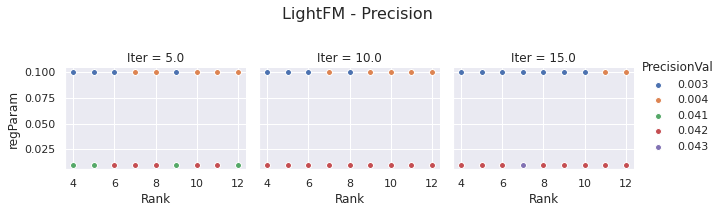

In [73]:
# Visualizations for precision_at_ks

graph = sns.FacetGrid(df_merged , col="Iter", hue="PrecisionVal")
graph.map(plt.scatter, "Rank" , "regParam"  , edgecolor="w").add_legend()
graph.fig.subplots_adjust(top=0.7)
graph.fig.suptitle("LightFM - Precision" , fontsize=16)
plt.show()

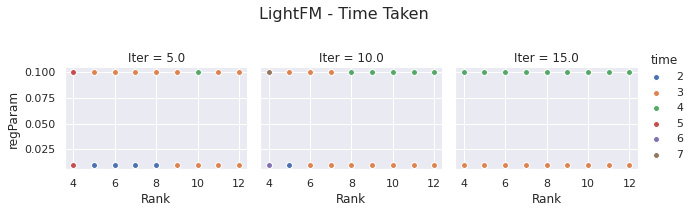

In [74]:
# Visualizations for times2

graph = sns.FacetGrid(df_merged , col="Iter", hue="time")
graph.map(plt.scatter, "Rank" , "regParam" , edgecolor="w").add_legend()
graph.fig.subplots_adjust(top=0.7)
graph.fig.suptitle("LightFM - Time Taken" , fontsize=16)
plt.show()

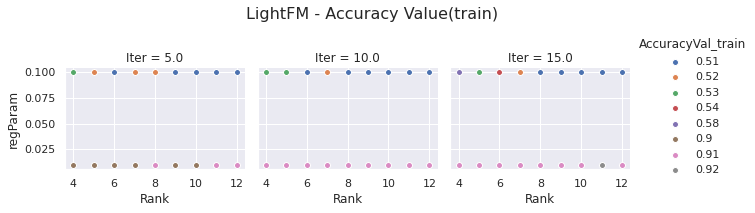

In [75]:
# Visualizations for auc_train

graph = sns.FacetGrid(df_merged , col="Iter", hue="AccuracyVal_train")
graph.map(plt.scatter, "Rank" , "regParam" , edgecolor="w").add_legend()
graph.fig.subplots_adjust(top=0.7)
graph.fig.suptitle("LightFM - Accuracy Value(train)" , fontsize=16)
plt.show()


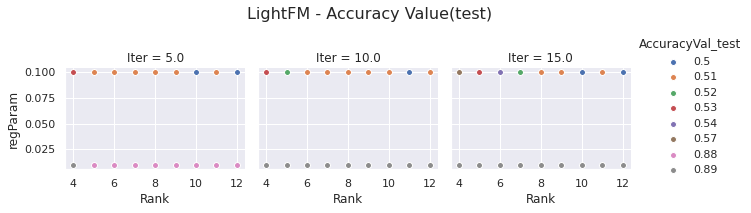

In [76]:
# Visualizations for auc_test

graph = sns.FacetGrid(df_merged , col="Iter", hue="AccuracyVal_test")
graph.map(plt.scatter, "Rank" , "regParam" , edgecolor="w").add_legend()
graph.fig.subplots_adjust(top=0.7)
graph.fig.suptitle("LightFM - Accuracy Value(test)" , fontsize=16)
plt.show()


# Annoy

In [77]:
%matplotlib inline
from sklearn.metrics import pairwise_distances
import time
from lightfm.datasets import fetch_movielens

movielens = fetch_movielens()

In [78]:
movielens.items()

dict_items([('train', <943x1682 sparse matrix of type '<class 'numpy.int32'>'
	with 90570 stored elements in COOrdinate format>), ('test', <943x1682 sparse matrix of type '<class 'numpy.int32'>'
	with 9430 stored elements in COOrdinate format>), ('item_features', <1682x1682 sparse matrix of type '<class 'numpy.float32'>'
	with 1682 stored elements in Compressed Sparse Row format>), ('item_feature_labels', array(['Toy Story (1995)', 'GoldenEye (1995)', 'Four Rooms (1995)', ...,
       'Sliding Doors (1998)', 'You So Crazy (1994)',
       'Scream of Stone (Schrei aus Stein) (1991)'], dtype=object)), ('item_labels', array(['Toy Story (1995)', 'GoldenEye (1995)', 'Four Rooms (1995)', ...,
       'Sliding Doors (1998)', 'You So Crazy (1994)',
       'Scream of Stone (Schrei aus Stein) (1991)'], dtype=object))])

In [79]:
#dividing the data into training and test
train = movielens['train']
test = movielens['test']

In [80]:
model = LightFM(learning_rate=0.05, loss='warp', no_components=64, item_alpha=0.001)
model.fit_partial(train, item_features=movielens['item_features'], epochs=20 )

#for storing the training and test precision
train_precision = precision_at_k(model, train, k=10).mean()
test_precision = precision_at_k(model, test, k=10).mean()

#for storing the training and test accuracy
train_auc = auc_score(model, train).mean()
test_auc = auc_score(model, test).mean()

print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

Precision: train 0.74, test 0.09.
AUC: train 0.97, test 0.91.


In [81]:
# Get embeddings
_, item_embeddings = model.get_item_representations(movielens['item_features'])

In [82]:
!pip install annoy

In [83]:
# Annoy index for item to item quering
from annoy import AnnoyIndex
# Length of item vector that will be indexed
factors = item_embeddings.shape[1] 
annoy_idx = AnnoyIndex(factors)  
for i in range(item_embeddings.shape[0]):
    v = item_embeddings[i]
    annoy_idx.add_item(i, v)

annoy_idx.build(10) # 10 trees
annoy_idx.save('movielens_item_Annoy_idx.ann')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  """


True

In [84]:
#Query for similar movies
def nearest_movies_annoy(movie_id, index, n=10, print_output=True):
    nn = index.get_nns_by_item(movie_id, 10)
    if print_output:
        print('Closest to %s : \n' % movielens['item_labels'][movie_id])
    titles = [movielens['item_labels'][i] for i in nn]
    if print_output:
        print("\n".join(titles))

In [85]:
nearest_movies_annoy(90, annoy_idx)

Closest to Nightmare Before Christmas, The (1993) : 

Nightmare Before Christmas, The (1993)
Beauty and the Beast (1991)
Lion King, The (1994)
Snow White and the Seven Dwarfs (1937)
Aladdin (1992)
E.T. the Extra-Terrestrial (1982)
Pink Floyd - The Wall (1982)
Cinderella (1950)
Dumbo (1941)
Star Trek: The Wrath of Khan (1982)


In [86]:
%%timeit
nearest_movies_annoy(90, annoy_idx, print_output=False)

The slowest run took 10.23 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 19.5 µs per loop


## Comparision

In [87]:
item_vectors = movielens['item_features'] * model.item_embeddings

In [88]:
  norms = np.linalg.norm(item_vectors, axis=1)
  max_norm = norms.max()
  extra_dimension = np.sqrt(max_norm ** 2 - norms ** 2)
  norm_data = np.append(item_vectors, extra_dimension.reshape(norms.shape[0], 1), axis=1)

  f_member = norm_data.shape[1]
  t_member = AnnoyIndex(f_member)  # Length of item vector that will be indexed

  for i in range(norm_data.shape[0]):
      v = norm_data[i]
      t_member.add_item(i, v)
      
  t_member.build(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  import sys


True

In [89]:
def recommend_without_ann(model, data, user_ids, print_output=True):
    n_users, n_items = data['train'].shape

    for user_id in user_ids:
        known_positives = data['item_labels'][data['train'].tocsr()[user_id].indices]
        scores = model.predict(user_id, np.arange(n_items))
        top_items = data['item_labels'][np.argsort(-scores)]
        if print_output == True:
            print("User %s" % user_id)
            print("     Known positives:")

            for x in known_positives[:3]:
                print("        %s" % x)

            print("     Recommended:")

            for x in top_items[:3]:
                print("        %s" % x)

In [90]:
recommend_without_ann(model, movielens, [3, 25, 450])

User 3
     Known positives:
        Seven (Se7en) (1995)
        Indiana Jones and the Last Crusade (1989)
        Contact (1997)
     Recommended:
        Contact (1997)
        Air Force One (1997)
        Conspiracy Theory (1997)
User 25
     Known positives:
        Toy Story (1995)
        Twelve Monkeys (1995)
        Dead Man Walking (1995)
     Recommended:
        Men in Black (1997)
        Fargo (1996)
        Independence Day (ID4) (1996)
User 450
     Known positives:
        Kolya (1996)
        Devil's Own, The (1997)
        Contact (1997)
     Recommended:
        Cop Land (1997)
        Conspiracy Theory (1997)
        Beautician and the Beast, The (1997)


In [91]:
user_vectors = model.user_embeddings

In [92]:
# Add a nomalizing factor to each item vector - 0 is added at the end
def normalize(item_vectors):
  norms = np.linalg.norm(item_vectors, axis=1)
  max_norm = norms.max()
  extra_dimension = np.sqrt(max_norm ** 2 - norms ** 2)
  norm_data = np.append(item_vectors, extra_dimension.reshape(norms.shape[0], 1), axis=1)

  f_member = norm_data.shape[1]
  t_member = AnnoyIndex(f_member)  # Length of item vector that will be indexed

  for i in range(norm_data.shape[0]):
      v = norm_data[i]
      t_member.add_item(i, v)
      
  t_member.build(10)

normalize(item_vectors)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  if __name__ == '__main__':


In [93]:
def recommend_with_ann(user_ids, model, data, n_items=10, print_output=True):
    n_users, n_items = data['train'].shape
    
    for user_id in user_ids:
        known_positives = data['item_labels'][data['train'].tocsr()[user_id].indices]
        top_items = [data['item_labels'][i] for i in t_member.get_nns_by_vector(np.append(user_vectors[user_id], 0), 50)]
        if print_output == True:
            print("User %s" % user_id)
            print("     Known positives:")

            for x in known_positives[:3]:
                print("        %s" % x)

            print("     Recommended:")

            for x in top_items[:3]:
                print("        %s" % x)

In [94]:
recommend_with_ann([3,25,450], model, movielens, print_output=True)

User 3
     Known positives:
        Seven (Se7en) (1995)
        Indiana Jones and the Last Crusade (1989)
        Contact (1997)
     Recommended:
        Contact (1997)
        Air Force One (1997)
        Conspiracy Theory (1997)
User 25
     Known positives:
        Toy Story (1995)
        Twelve Monkeys (1995)
        Dead Man Walking (1995)
     Recommended:
        Men in Black (1997)
        Independence Day (ID4) (1996)
        Mission: Impossible (1996)
User 450
     Known positives:
        Kolya (1996)
        Devil's Own, The (1997)
        Contact (1997)
     Recommended:
        Cop Land (1997)
        Hoodlum (1997)
        Beautician and the Beast, The (1997)


In [95]:
%%timeit
recommend_without_ann(model, movielens, [3, 25, 450], print_output=False)

100 loops, best of 5: 6.67 ms per loop


In [96]:
%%timeit
recommend_with_ann([3,25,450], model, movielens, print_output=False)

100 loops, best of 5: 4.98 ms per loop


In [97]:
from time import time
without_ann = {}
with_ann = {}

df_without_ann = pd.DataFrame(columns = ['Rank' , 'Iter' , 'regParam' , 't1'])
df_with_ann = pd.DataFrame(columns = ['Rank' , 'Iter' , 'regParam' , 't2'])

for r in ranks:
  for Iter in maxIters:
    for reg in regParams:
      #Lighfm
      model = LightFM(loss='warp',
                no_components=r,
                user_alpha=reg)

      model = model.fit(train, epochs=Iter,verbose=False)
      st = time()
      for _ in range(1000):
        recommend_without_ann(model, movielens, [3, 25, 450], print_output=False)
      t1 = round(time()-st, 5)
      # Annoy
      item_vectors = movielens['item_features'] * model.item_embeddings
      normalize(item_vectors)
      st = time()
      for _ in range(1000):
        recommend_with_ann([3,25,450], model, movielens, print_output=False)
      t2 = round(time()-st, 5)
      without_ann[(r,Iter,reg)] = t1
      with_ann[(r,Iter,reg)] = t2

      df_without_ann = df_without_ann.append({'Rank' : r , 'Iter' : Iter , 'regParam' : reg , 't1' : t1} , ignore_index = True)
      df_with_ann = df_with_ann.append({'Rank' : r , 'Iter' : Iter , 'regParam' : reg , 't2' : t2} , ignore_index = True)

      print('Model with maxIter = {}, reg = {}, rank = {} complete'.format(Iter,reg,r))
      print('Without Annoy =',t1,'With Annoy =',t2)

df_without_ann["t1"] = df_without_ann["t1"].astype(int)
df_with_ann["t2"] = df_with_ann["t2"].astype(int)

df_merged2 = df_without_ann.merge(df_with_ann , on=('Iter' , 'Rank' , 'regParam') , how="inner")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  if __name__ == '__main__':


Model with maxIter = 5, reg = 0.1, rank = 4 complete
Without Annoy = 8.41735 With Annoy = 6.19279
Model with maxIter = 5, reg = 0.01, rank = 4 complete
Without Annoy = 5.68738 With Annoy = 2.92289
Model with maxIter = 10, reg = 0.1, rank = 4 complete
Without Annoy = 4.0509 With Annoy = 2.88095
Model with maxIter = 10, reg = 0.01, rank = 4 complete
Without Annoy = 4.0589 With Annoy = 2.95512
Model with maxIter = 15, reg = 0.1, rank = 4 complete
Without Annoy = 4.08074 With Annoy = 2.9442
Model with maxIter = 15, reg = 0.01, rank = 4 complete
Without Annoy = 4.1055 With Annoy = 2.95739
Model with maxIter = 5, reg = 0.1, rank = 5 complete
Without Annoy = 4.07859 With Annoy = 2.94121
Model with maxIter = 5, reg = 0.01, rank = 5 complete
Without Annoy = 4.05134 With Annoy = 2.92188
Model with maxIter = 10, reg = 0.1, rank = 5 complete
Without Annoy = 4.09627 With Annoy = 2.97057
Model with maxIter = 10, reg = 0.01, rank = 5 complete
Without Annoy = 4.09495 With Annoy = 2.92046
Model with ma

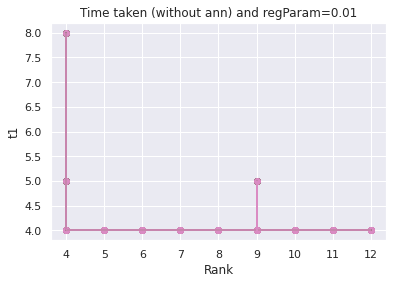

In [98]:
#graph plot for t1 (without ann)
for x in df_merged2['regParam']:
    if x == 0.01:
        x_values = df_merged2['Rank']
        y_values = df_merged2['t1']
        plt.plot(x_values,y_values)
        plt.scatter(x_values,y_values)
        plt.xlabel("Rank")
        plt.ylabel("t1")
        plt.title("Time taken (without ann) and regParam=0.01")
    else:
        pass

plt.show()

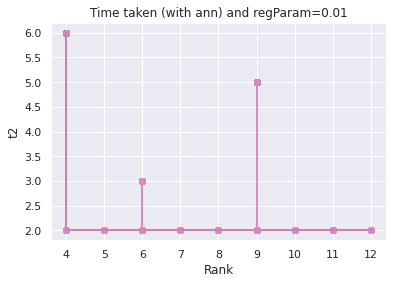

In [99]:
#graph plot for t1 (without ann)
for x in df_merged2['regParam']:
    if x == 0.01:
        x_values = df_merged2['Rank']
        y_values = df_merged2['t2']
        plt.plot(x_values,y_values)
        plt.scatter(x_values,y_values)
        plt.xlabel("Rank")
        plt.ylabel("t2")
        plt.title("Time taken (with ann) and regParam=0.01")
    else:
        pass

plt.show()

# Visualization

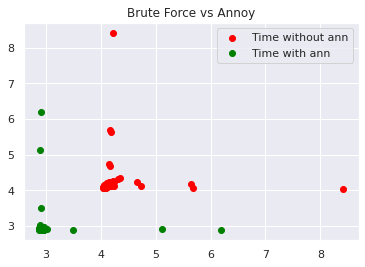

In [100]:
import matplotlib.pyplot as plt

#for plotting t1(time taken without ann) and t2(time taken with ann) 

x = list(without_ann.values())
y = sorted(x)

x2 = list(with_ann.values())
y2 = sorted(x2)

fig, ax = plt.subplots()
ax.scatter(x, y,color="red", label="Time without ann")
ax.scatter(x2,y2,color='green', label="Time with ann")
plt.title("Brute Force vs Annoy")
ax.legend()
plt.show()